Cell 1 (imports + DB connection)

In [1]:
from pathlib import Path

import sqlite3

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

project_root = Path.cwd().parent

db_path = project_root / "data" / "Synthetic Dataset" / "product_analytics.db"

conn = sqlite3.connect(db_path)

Cell 2 (pull order level data)

In [3]:
query = """

SELECT

    user_id,

    DATE(order_ts) AS order_day

FROM orders;

"""

orders = pd.read_sql_query(query, conn)

orders["order_day"] = pd.to_datetime(orders["order_day"])

orders.head()

,user_id,order_day
0,2466,2024-01-01
1,710,2024-01-01
2,2675,2024-01-01
3,817,2024-01-01
4,3031,2024-01-01


Cell 3 (define each users cohort "first order month")

In [4]:
cohorts = (

    orders.groupby("user_id")["order_day"]

          .min()

          .dt.to_period("M")

          .rename("cohort_month")

)

orders = orders.merge(cohorts, on="user_id")

orders.head()

,user_id,order_day,cohort_month
0,2466,2024-01-01,2024-01
1,710,2024-01-01,2024-01
2,2675,2024-01-01,2024-01
3,817,2024-01-01,2024-01
4,3031,2024-01-01,2024-01


Key Idea - Every user has a starting point in time.

Cell 4 (calculate "month since cohort")

    - This creates the retention clock.

In [5]:
orders["order_month"] = orders["order_day"].dt.to_period("M")

orders["cohort_index"] = (

    orders["order_month"] - orders["cohort_month"]
    
).apply(lambda x: x.n)

orders.head()

,user_id,order_day,cohort_month,order_month,cohort_index
0,2466,2024-01-01,2024-01,2024-01,0
1,710,2024-01-01,2024-01,2024-01,0
2,2675,2024-01-01,2024-01,2024-01,0
3,817,2024-01-01,2024-01,2024-01,0
4,3031,2024-01-01,2024-01,2024-01,0


Cell 5 (builds the retention table)

    - Counts active users per month.

In [6]:
cohort_counts = (

    orders.groupby(["cohort_month", "cohort_index"])["user_id"]

          .nunique()

          .reset_index()

)

cohort_counts.head()

,cohort_month,cohort_index,user_id
0,2024-01,0,358
1,2024-01,1,26
2,2024-01,2,35
3,2024-01,3,20
4,2024-01,4,39


Cell 6 (convert to retention matrix)

     - Normalize by cohort size.

In [7]:
cohort_size = (

    cohort_counts[cohort_counts["cohort_index"] == 0]

    .set_index("cohort_month")["user_id"]

)

retention = cohort_counts.pivot(

    index="cohort_month",

    columns="cohort_index",

    values="user_id"

)

retention = retention.divide(cohort_size, axis=0)

retention

cohort_index,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cohort_month,,,,,,,,,,,,,,,,,,,,,
2024-01,1.0,0.072626,0.097765,0.055866,0.108939,0.055866,0.081006,0.061453,0.069832,0.069832,...,0.094972,0.083799,0.089385,0.078212,0.061453,0.050279,0.078212,0.067039,0.075419,0.067039
2024-02,1.0,0.063037,0.068768,0.077364,0.074499,0.071633,0.065903,0.088825,0.077364,0.065903,...,0.077364,0.080229,0.063037,0.054441,0.063037,0.071633,0.068768,0.085960,0.091691,NaN
2024-03,1.0,0.047170,0.088050,0.066038,0.062893,0.072327,0.056604,0.072327,0.053459,0.084906,...,0.056604,0.069182,0.059748,0.066038,0.072327,0.081761,0.062893,0.075472,NaN,NaN
2024-04,1.0,0.063158,0.059649,0.063158,0.094737,0.073684,0.080702,0.080702,0.070175,0.066667,...,0.056140,0.066667,0.063158,0.073684,0.045614,0.049123,0.063158,NaN,NaN,NaN
2024-05,1.0,0.090909,0.090909,0.079051,0.075099,0.079051,0.071146,0.055336,0.083004,0.075099,...,0.043478,0.067194,0.071146,0.059289,0.098814,0.079051,NaN,NaN,NaN,NaN
2024-06,1.0,0.034188,0.081197,0.064103,0.094017,0.072650,0.085470,0.089744,0.081197,0.064103,...,0.072650,0.059829,0.076923,0.029915,0.068376,NaN,NaN,NaN,NaN,NaN
2024-07,1.0,0.038314,0.111111,0.045977,0.084291,0.068966,0.111111,0.084291,0.072797,0.080460,...,0.072797,0.076628,0.057471,0.091954,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,1.0,0.057895,0.078947,0.084211,0.089474,0.089474,0.063158,0.068421,0.047368,0.073684,...,0.084211,0.073684,0.073684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,1.0,0.058252,0.077670,0.111650,0.077670,0.043689,0.043689,0.087379,0.063107,0.072816,...,0.072816,0.058252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- This matrix is the core artifact

Cell 7 (visualize retention)

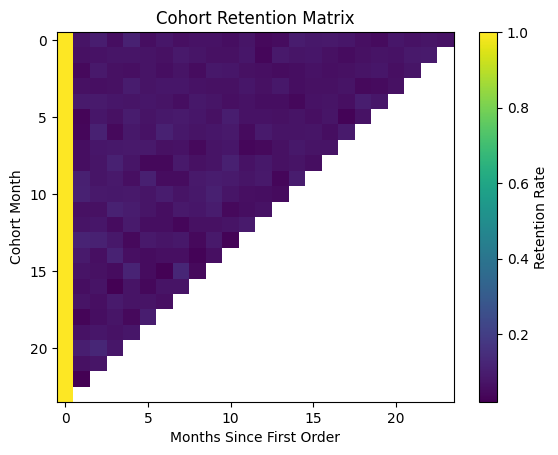

In [8]:
plt.figure()

plt.imshow(retention, aspect="auto")

plt.colorbar(label="Retention Rate")

plt.title("Cohort Retention Matrix")

plt.xlabel("Months Since First Order")

plt.ylabel("Cohort Month")

plt.show()

Cell 9 (average retention curve)

   -Collapse across cohorts.

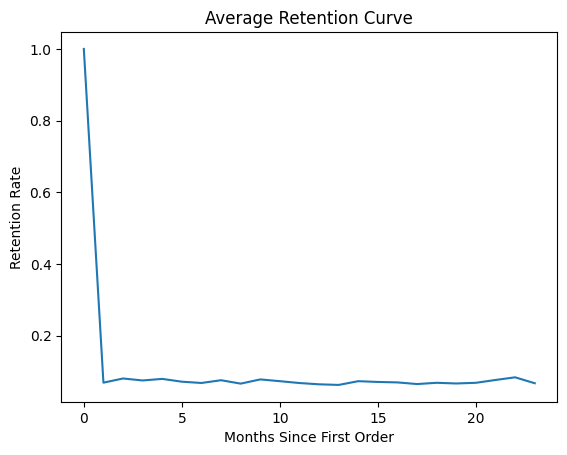

In [9]:
avg_retention = retention.mean()

avg_retention.plot(title="Average Retention Curve")

plt.xlabel("Months Since First Order")

plt.ylabel("Retention Rate")

plt.show()

- "Decay Curve"

## Day 5 - Cohort Retention Insights
        
        - Retention declines as cohort_index increases, indicating natural user decay.
        - Early cohorts show similar decay patterns, suggesting stable lifecycle behavior.
        - Long tail retention is driven by a small subset of persistent users.
        - This mirrors signal decay patterns seen in financial strategies.

        Cohort analysis provides a time aware view of behavior persistence.
